In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as Pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

# libraries that used to turn off warnings.
import warnings
warnings. filterwarnings('ignore')

# libraries to be used for model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# libraries to be used for the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint ,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [ ]:
# loading dataset
dir_path = "/content/drive/MyDrive/data1a/training"

validation_path = "/content/drive/MyDrive/data1a/validation"

In [ ]:
target_size = (224,224)

pred_labels = {'01-whole':0,'00-damage':1}

In [ ]:
def load_datasets(path):
  """
  It reads the image in the directory containing the images and creates tags.
  Parameters :
  path: Refers to the directory where the images are located.
  Return:
  x: Holds matrix information of images.
  labels: List containing the class information to which the image belongs.
  """
  x = []
  labels = []

  # It lists and sorts the images in the path we send.
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths :
    # Images in the specified path are read with the openCV library.
    img = cv2.imread(image_path)
    # Read images are rescaled according to the initially specified target_size.
    img = cv2.resize(img, target_size)
    # Scaled images are added to the x list.
    x.append(img)
    # When each path is separated by the ' / ' expression, the second to last element of the returned list represents labe11.
    label = image_path.split(os.path.sep)[-2]
    # Appending labels with waste labels key - value
    labels.append(pred_labels[label])

    # The data set is shuffled randomly.
  x, labels = shuffle(x, labels, random_state=42)
  # Size and Class Information is reported.
  print(f"X size: {np.array(x).shape}")
  print(f"Label class length: {len(np.unique(labels))} Observation Length: {len(labels)}")
  return x, labels

In [ ]:
x, labels = load_datasets(dir_path)
x_val, labels_val = load_datasets(validation_path)

X size: (1840, 224, 224, 3)
Label class length: 2 Observation Length: 1840
X size: (460, 224, 224, 3)
Label class length: 2 Observation Length: 460


In [ ]:
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1],3)
print(input_shape)

input_shape_val = (np.array(x_val[0]).shape[1], np.array(x_val[0]).shape[1],3)
print(input_shape_val)

(224, 224, 3)
(224, 224, 3)


In [ ]:
# visualizing image
def visualize_image(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax=plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(pred_labels.keys()))[to_categorical(labels,num_classes=2)[n]==1][0].title())
    plt.axis('off')

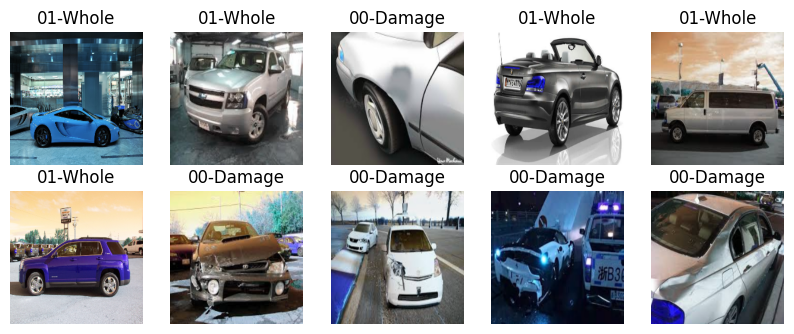

In [ ]:
visualize_image(x,labels)

In [ ]:
# data augmentation
# We define a generator for the train data set.
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

# We define a generator for the test data set.
test = ImageDataGenerator(rescale=1/255)

In [20]:
train_generator = train.flow_from_directory(directory=dir_path,
                                            target_size=(target_size),
                                            class_mode='categorical',
                                            subset='training')

val_generator = test.flow_from_directory(directory=validation_path,
                                         target_size=(target_size),
                                         batch_size=251,
                                         class_mode='categorical',
                                         shuffle=False)


"""
test_generator = test.flow_from_directory(directory=validation_path,
                                          target_size=(target_size),
                                          batch_size=251,
                                          class_mode='categorical',
                                          subset='validation')
"""

Found 1656 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


"\ntest_generator = test.flow_from_directory(directory=validation_path,\n                                          target_size=(target_size),\n                                          batch_size=251,\n                                          class_mode='categorical',\n                                          subset='validation')\n"

In [21]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',input_shape=(input_shape),activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2)) # to prevent overfitting
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=2,activation='sigmoid')) # it is a 6-class classification problem, unit=6
# class > 2 -> softmax | class <= 2 -> sigmoid


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [23]:
model.compile(loss = 'binary_crossentropy', # because target class > 2, if categoricall class==2, we use binary_crossentropy
              optimizer ='adam', # alternatively we can use 'scd'
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'acc'])

In [24]:

callbacks = [EarlyStopping(monitor='val_loss', patience=30, verbose =1, mode='min'),
             ModelCheckpoint(filepath='carpredmodel_2.h5', monitor='val_loss', mode='min', save_best_only=True, save_weight_only=False, verbose = 1)]


In [25]:
history = model.fit_generator(generator=train_generator,
                              epochs = 60,
                              validation_data=val_generator,
                              callbacks=callbacks,
                              workers = 4,
                              steps_per_epoch = 1840//32,
                              validation_steps = 460//32)

Epoch 1/60
57/57 [==============================] - ETA: 0s - loss: 0.7007 - precision: 0.4946 - recall: 0.5846 - acc: 0.4884
Epoch 1: val_loss improved from inf to 0.69315, saving model to carpredmodel_2.h5
57/57 [==============================] - 337s 6s/step - loss: 0.7007 - precision: 0.4946 - recall: 0.5846 - acc: 0.4884 - val_loss: 0.6931 - val_precision: 0.5083 - val_recall: 0.5978 - val_acc: 0.5152
Epoch 2/60
57/57 [==============================] - ETA: 0s - loss: 0.6920 - precision: 0.5118 - recall: 0.5743 - acc: 0.5066
Epoch 2: val_loss improved from 0.69315 to 0.68003, saving model to carpredmodel_2.h5
57/57 [==============================] - 357s 6s/step - loss: 0.6920 - precision: 0.5118 - recall: 0.5743 - acc: 0.5066 - val_loss: 0.6800 - val_precision: 0.5054 - val_recall: 0.5109 - val_acc: 0.5043
Epoch 3/60
57/57 [==============================] - ETA: 0s - loss: 0.6764 - precision: 0.5744 - recall: 0.6674 - acc: 0.5892
Epoch 3: val_loss improved from 0.68003 to 0.67577

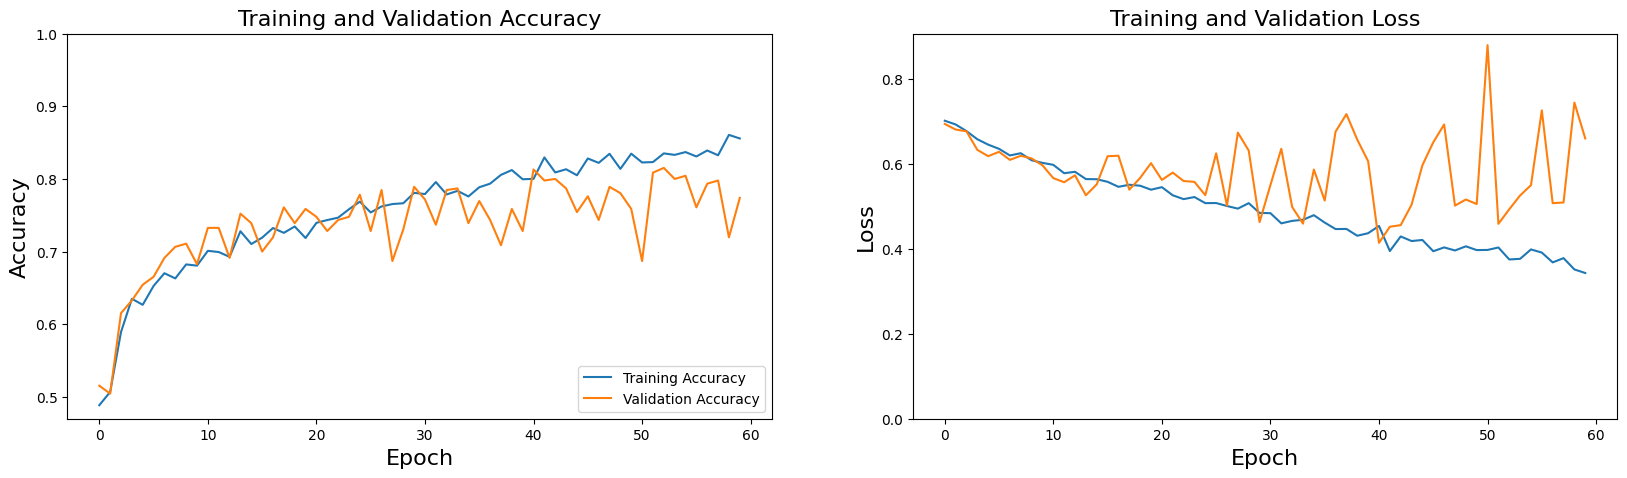

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontsize=16)


plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss',fontsize=16)
plt.show()